## Sample reduction variable, library imports, data import

### Sample scaling (downsampling for development purposes)

In [1]:
sample_size_ratio_config = 1 # sample_size = 1 means that all data will be used.
test_run = 0 # Set to 1 to just check for syntax and run with very small sample

### Imports except for model-specific sklearn imports

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from IPython.display import Image

# for plotting charts
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

#statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats

#### Additional libraries

In [3]:
import matplotlib.pyplot as plt
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D

#### Data import

In [4]:
df = pd.read_csv("Intelligent_Couponing.csv")
if test_run == 1:
    rows = np.random.choice(df.index.values, 1000)
    df = df.ix[rows]
if sample_size_ratio_config != 1:
    import math
    df = df.sample(n=math.floor(sample_size_ratio_config*len(df.count())))
number_observations_original = df.customernumber.count()

/home/janspoerer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Business problem

### Why is the dependent variable important to know?
* The dependent variable indicates if a given customer will re-order within 90 days without getting a voucher.
* It is relevant because if a customer is likely to re-order within 90 days without getting a voucher, it may not make economic sense to provide him with a voucher.
* The voucher is worth 5 EUR.

### Limitations of the analysis:
* To evaluate the imporance of this order (i.e., the contribution margin), one actually needs to be able to approximate the expected contribution margin for the next order.
* In addition to the contribution margin of the next order, the change in customer lifetime value is imporant to estimate.
* The customer lifetime value in case of providing the customer with a voucher vs. not providing the customer with a voucher is the main concern. 
* The customer lifetime value could be approximated by the expected past contribution margin and by the purchasing behavior of the customer. 
* Here, do not directly calculate the customer lifetime value.
* We also don't have enough information to calculate the expected contribution margin over the next 90 days.

## Exploratory Data Analysis

Content

### Table of Content 

* Variable Indentification
    * How does the data look like?
    * Data type & basic statistics (central tendency and spread for continous; count for categorical)
    * How do my variables look like? (predictor & target, continous & categorical, data types)
* Uni-variate Analyisis
    * Countinous variables - Do we have outliers?
    * Categorical variables - What is the share of each category?
* Bi-variante Analysis 
    * Target variable to categorical variables
     * Chi square test - Are there any significant associations between the two variables?
* Correlation with target variable

### Variable Identification
#### How does the data looks like?

In [5]:
print(df.head())

   customernumber        date  salutation  title  domain datecreated  \
0           41191  2008-12-01           0      0       9  2008-12-01   
1           38860  2008-12-16           1      0       4  2008-12-16   
2           61917  2008-08-19           0      0      12  2008-08-19   
3           40647  2008-06-16           1      0       8  2008-06-16   
4            1347  2008-08-08           0      0       1  2008-08-08   

   newsletter  model  paymenttype  deliverytype    ...     w2 w3  w4 w5  w6  \
0           0      2            2             0    ...      0  0   0  0   0   
1           0      1            1             1    ...      0  0   0  0   0   
2           0      1            0             0    ...      0  0   0  0   0   
3           0      1            0             0    ...      0  0   0  2   0   
4           0      1            1             1    ...      2  0   0  0   0   

   w7  w8  w9  w10  target90  
0   0   0   0    0         0  
1   0   0   0    0         0  

#### Data Types & Basic Description 

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32428 entries, 0 to 32427
Data columns (total 38 columns):
customernumber          32428 non-null int64
date                    32428 non-null object
salutation              32428 non-null int64
title                   32428 non-null int64
domain                  32428 non-null int64
datecreated             32428 non-null object
newsletter              32428 non-null int64
model                   32428 non-null int64
paymenttype             32428 non-null int64
deliverytype            32428 non-null int64
invoicepostcode         32428 non-null int64
delivpostcode           1392 non-null object
voucher                 32428 non-null int64
advertisingdatacode     6523 non-null object
case                    32428 non-null int64
numberitems             32428 non-null int64
gift                    32428 non-null int64
entry                   32428 non-null int64
points                  32428 non-null int64
shippingcosts           32428 non-

In [7]:
print(df.describe())

       customernumber    salutation         title        domain    newsletter  \
count    32428.000000  32428.000000  32428.000000  32428.000000  32428.000000   
mean     33389.298569      0.541569      0.006969      7.517115      0.169483   
std      19148.090449      0.657044      0.083192      3.683945      0.375184   
min          1.000000      0.000000      0.000000      0.000000      0.000000   
25%      16802.750000      0.000000      0.000000      4.000000      0.000000   
50%      33552.500000      0.000000      0.000000      9.000000      0.000000   
75%      50034.250000      1.000000      0.000000     11.000000      0.000000   
max      66251.000000      2.000000      1.000000     12.000000      1.000000   

              model   paymenttype  deliverytype  invoicepostcode  \
count  32428.000000  32428.000000  32428.000000     32428.000000   
mean       1.646910      1.000987      0.201955        48.752282   
std        0.825981      1.092677      0.401465        24.361425  

In [8]:
print(df.notnull().all())

customernumber           True
date                     True
salutation               True
title                    True
domain                   True
datecreated              True
newsletter               True
model                    True
paymenttype              True
deliverytype             True
invoicepostcode          True
delivpostcode           False
voucher                  True
advertisingdatacode     False
case                     True
numberitems              True
gift                     True
entry                    True
points                   True
shippingcosts            True
deliverydatepromised     True
deliverydatereal         True
weight                   True
remi                     True
cancel                   True
used                     True
w0                       True
w1                       True
w2                       True
w3                       True
w4                       True
w5                       True
w6                       True
w7        

#### How does my variable look like?

Target variable = target90 (n=1)

Predictor variables (n=31)
* To be dropped: customernumber, model, invoicepostcode, gift, points, title, delivpostcode, title, advertisingdatacode, remi, cancel, used
* To be transformed: date, datecreated, deliverydatepromised, deliverydatereal
* Probably highly correlated to other variables: entry, shippingcosts, deliverytype, numberitems, weight
* Others: voucher, case, newsletter, salutation, domain, paymenttype, product categories (w0 to w10)

Data types
* Object
    * date
    * datecreated
    * delivpostcode
    * advertisingdatacode
    * deliverydatepromised
    * deliverydatereal
* int: The rest variables are int type

Variable category
* Continuous
    * weight
    * numberofitems
    * used
    * w0 ... w10
* Categorical: The rest

In [9]:
df = pd.read_csv("Intelligent_Couponing.csv")
if test_run == 1:
    rows = np.random.choice(df.index.values, 1000)
    df = df.ix[rows]
if sample_size_ratio_config != 1:
    import math
    df = df.sample(n=math.floor(sample_size_ratio_config*len(df.count())))
number_observations_original = df.customernumber.count()

### Uni-variate analysis
#### Continuous variables (while also plotting the categorical variables)

In [10]:
plt.figure(figsize=(19,19))
#sns.boxplot(df['weight'].values)
from sklearn.preprocessing import StandardScaler 
sc_x=StandardScaler()
data_box=df.copy()
del data_box['date']
del data_box['datecreated']
del data_box['deliverydatepromised']
del data_box['deliverydatereal']
del data_box['advertisingdatacode']
#del data_box['postcode']

<Figure size 1368x1368 with 0 Axes>

In [11]:
#data_box=df.drop('datecreated',0)
#data_box=df.drop('deliverydatepromised',0)
#data_box=df.drop('deliverydatereal',0)
del data_box['invoicepostcode']
del data_box['delivpostcode']
#box.boxplot()

In [12]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc_x=StandardScaler()
mm_x=MinMaxScaler()

/home/janspoerer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


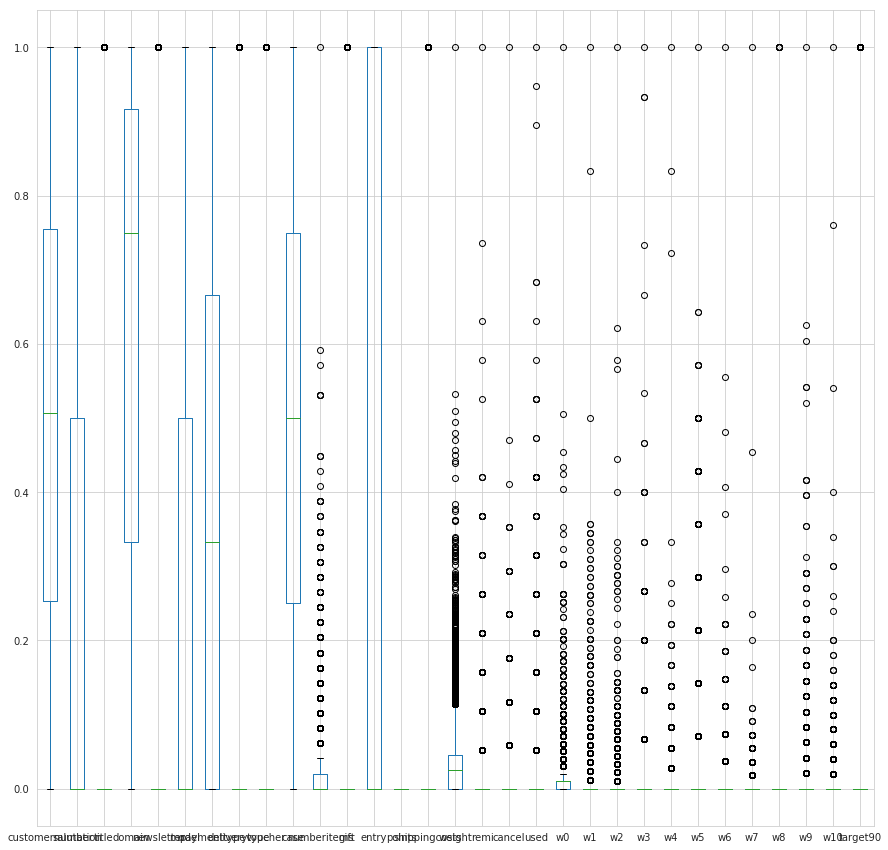

In [13]:
data_box.iloc[:,:]=mm_x.fit_transform(data_box.iloc[:,:])
#boxframe=pd.DataFrame(data_final)
#boxframe.boxplot()
plt.figure(figsize=(15,15))
data_box.boxplot()

Why do we have weights that equal 0? Because there are intangible items (audio books and other data-based items).

In [14]:
distribution of product categores w1 - w10

SyntaxError: invalid syntax (<ipython-input-14-93902532981e>, line 1)

/home/janspoerer/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


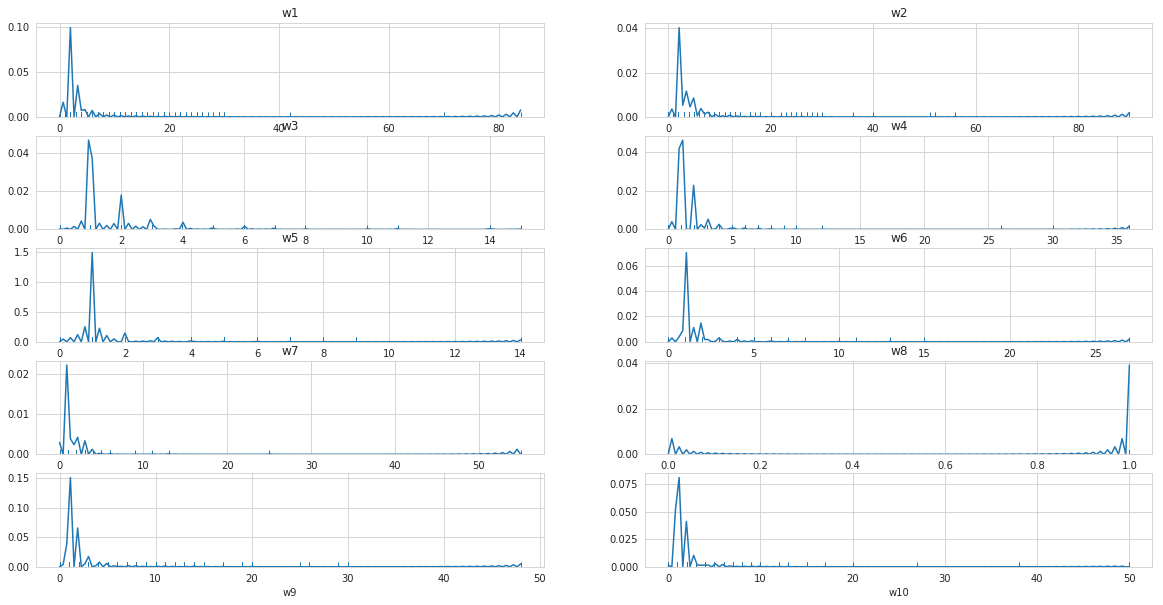

In [15]:
plt.figure(figsize=(20,10))

plt.subplot(5,2,1)
sns.distplot(df['w1'], rug = True, hist = False)
plt.title('w1')

plt.subplot(5,2,2)
sns.distplot(df['w2'], rug = True, hist = False)
plt.title('w2')

plt.subplot(5,2,3)
sns.distplot(df['w3'], rug = True, hist = False)
plt.title('w3')

plt.subplot(5,2,4)
sns.distplot(df['w4'], rug = True, hist = False)
plt.title('w4')

plt.subplot(5,2,5)
sns.distplot(df['w5'], rug = True, hist = False)
plt.title('w5')

plt.subplot(5,2,6)
sns.distplot(df['w6'], rug = True, hist = False)
plt.title('w6')

plt.subplot(5,2,7)
sns.distplot(df['w7'], rug = True, hist = False)
plt.title('w7')

plt.subplot(5,2,8)
sns.distplot(df['w8'], rug = True, hist = False)
plt.title('w8')

plt.subplot(5,2,9)
sns.distplot(df['w9'], rug = True, hist = False)

plt.subplot(5,2,10)
sns.distplot(df['w10'], rug = True, hist = False)

plt.show()

#### Categorical Data - understand the distribution of each category
Category data may have more than one category

In [16]:
df

customernumber        date  salutation  title  domain datecreated  \
0               41191  2008-12-01           0      0       9  2008-12-01   
1               38860  2008-12-16           1      0       4  2008-12-16   
2               61917  2008-08-19           0      0      12  2008-08-19   
3               40647  2008-06-16           1      0       8  2008-06-16   
4                1347  2008-08-08           0      0       1  2008-08-08   
5                4686  2008-08-10           0      0      12  2008-08-10   
6               28710  2008-12-21           0      0      12  2008-12-21   
7                 910  2008-09-04           0      0       9  2008-09-04   
8               50115  2008-06-25           0      0      12  2008-06-24   
9               52153  2008-08-02           0      0      12  2008-08-02   
10               6422  2008-12-20           1      0       9  2008-12-20   
11              40264  2008-04-01           2      0       6  2008-04-01   
12              48088  2008-09-12           0      0       4  2008-09-12   
13              12934  2008-05-06           1      0       6  2008-05-06   
14              30281  2008-10-02           0      0       9  2008-10-02   
15              54674  2008-04-02           2      0      12  2008-04-02   
16              24570  2008-12-08           0      0       6  2008-12-08   
17              44942  2008-12-20           1      0      12  2008-12-20   
18              38706  2008-11-18           1      0       8  2008-11-18   
19              36886  2008-07-15           0      0       8  2008-07-15   
20              59933  2008-10-03           0      0       1  2008-10-03   
21              25204  2008-10-20           0      0       1  2008-10-20   
22               7014  2008-11-27           2      0       8  2008-11-21   
23               4444  2008-12-30           0      0       9  2008-12-30   
24              60939  2008-04-13           1      0      12  2008-04-13   
25              27592  2008-04-25           2      0      12  2008-04-25   
26              46596  2008-08-30           0      0       9  2008-08-30   
27              12570  2008-05-17           1      0      12  2008-05-17   
28              20912  2008-08-24           0      0       9  2008-08-24   
29              13839  2008-12-19           1      0       4  2008-12-19   
...               ...         ...         ...    ...     ...         ...   
32398           16739  2008-07-29           1      0       9  2008-07-29   
32399           27665  2008-12-02           1      0       9  2008-12-02   
32400           28198  2008-11-02           0      0       9  2008-11-02   
32401           27827  2008-12-20           1      0       9  2008-12-20   
32402           65819  2008-07-15           0      0       9  2008-07-15   
32403           45829  2008-10-23           1      0       8  2008-10-23   
32404           38656  2008-10-03           1      0      12  2008-10-03   
32405           61080  2008-09-15           0      0       9  2008-09-15   
32406           39820  2008-11-10           1      0      12  2008-11-10   
32407           46719  2008-11-11           1      0      12  2008-11-11   
32408           24430  2008-10-14           1      0       9  2008-10-14   
32409           42975  2008-09-25           1      0      11  2008-09-25   
32410           24126  2008-11-05           0      0       4  2008-11-05   
32411           31409  2008-06-08           1      0       8  2008-06-08   
32412           34899  2008-05-13           0      0       9  2008-05-13   
32413           30887  2008-05-05           0      0      12  2008-05-05   
32414           35877  2008-12-16           1      0       9  2008-12-16   
32415           28917  2008-10-29           0      0       8  2008-10-29   
32416            1732  2008-10-26           0      0      12  2008-10-26   
32417           44335  2008-09-07           0      0       2  2008-09-07   
32418           15674  2008-11-01           0      0   

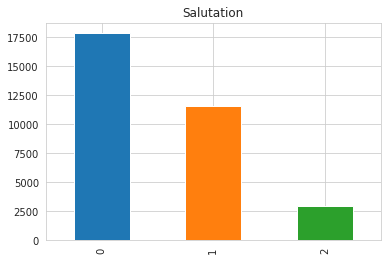

In [17]:
df = df.sort_values(by=['salutation'])
df['salutation'].value_counts().plot(kind = 'bar')
plt.title('Salutation')
plt.show()
# 0 mean Ms. 1 means Mr. and 2 means company - More female shopper in our dataset

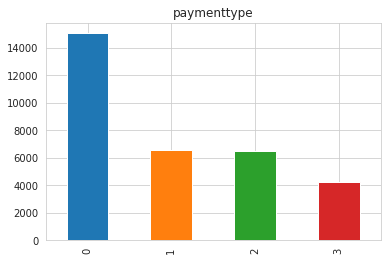

In [18]:
df = df.sort_values(by=['paymenttype'])
df['paymenttype'].value_counts().plot(kind = 'bar')
plt.title('paymenttype')
plt.show()

#0 - payment on invoice, 1- cash payment, 2 -transfer from current account, 3 - transfer from credit card
# most made payment on invoice

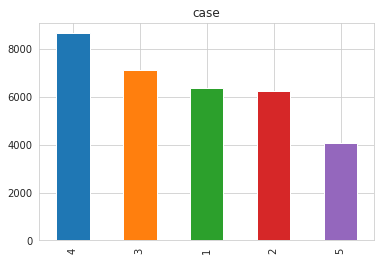

In [19]:
df = df.sort_values(by=['case'])
df['case'].value_counts().plot(kind = 'bar')
plt.title('case')
plt.show()

# value of goods,ranking from low to high, with 1 to be the lowest and 5 to be the highest

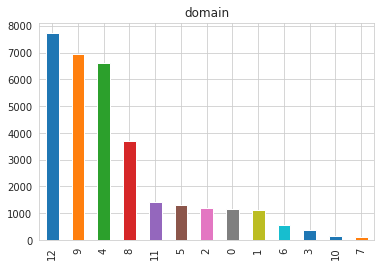

In [20]:
df = df.sort_values(by=['domain'])
df['domain'].value_counts().plot(kind = 'bar')
plt.title('domain')
plt.show()

# assumption: the domain of the user might indicates how sophisticated they are
# 9 - web.de domain  3 - gmail domain

Data which has either yes or no entry

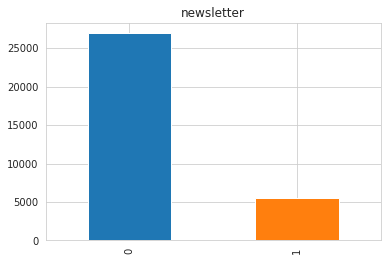

In [21]:
df = df.sort_values(by=['newsletter'])
df['newsletter'].value_counts().plot(kind = 'bar')
plt.title('newsletter')
plt.show()

# 0 no subscribtion, 1 - subscribtion

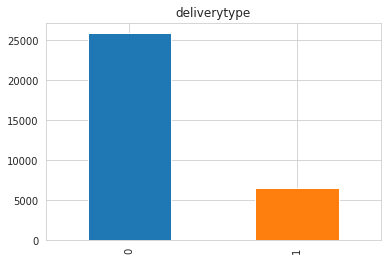

In [22]:
df = df.sort_values(by=['deliverytype'])
df['deliverytype'].value_counts().plot(kind = 'bar')
plt.title('deliverytype')
plt.show()

# 0 -dispatch, 1 collection

In [23]:
df = df.sort_values(by=['voucher'])
df['voucher'].value_counts().plot(kind = 'bar')
plt.title('voucher')
plt.show()

# 0 - no voucher has been cashed , 1 -yes

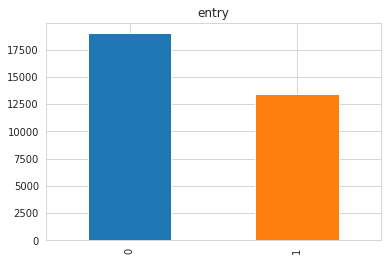

In [24]:
df = df.sort_values(by=['entry'])
df['entry'].value_counts().plot(kind = 'bar')
plt.title('entry')
plt.show()

# 0 - no entry in the shop, 1 -entry in the shop

In [25]:
df = df.sort_values(by=['shippingcosts'])
df['shippingcosts'].value_counts().plot(kind = 'bar')
plt.title('shippingcosts')
plt.show()

# 0 - no shipping cost incurred, yes - with shipping cost
# why: might due to our e-books, films or some discouts of shipping cost if we have large amount

### Bi-Variate Analysis
Target 90 against other categorical variables
Chi-squred to test association (if knowing A will help you to predict B)

In [26]:
# Target90 against salutation (female, male or company)
df_group1 = df.groupby(['target90','salutation'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

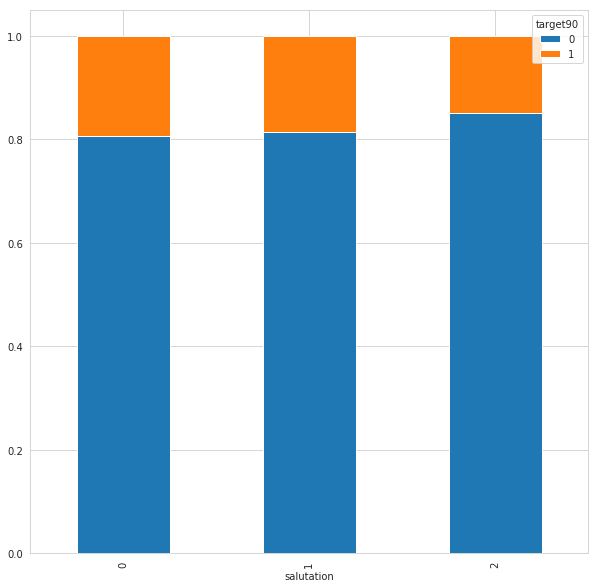

In [27]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

* Corporations seem less likely to reorder in 90 days.

* Null-hypothesis: Variables are indenpent
* Chi-square test for the independance between target90 and gender
* Results shows that they are dependent

In [28]:
scipy.stats.chi2_contingency(df_group1)

(0.007927412007346434, 0.996044139110304, 2, array([[0.82402219, 0.17597781],
        [0.82402219, 0.17597781],
        [0.82402219, 0.17597781]]))

In [29]:
# Target90 against newsletter
df_group1 = df.groupby(['target90','newsletter'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

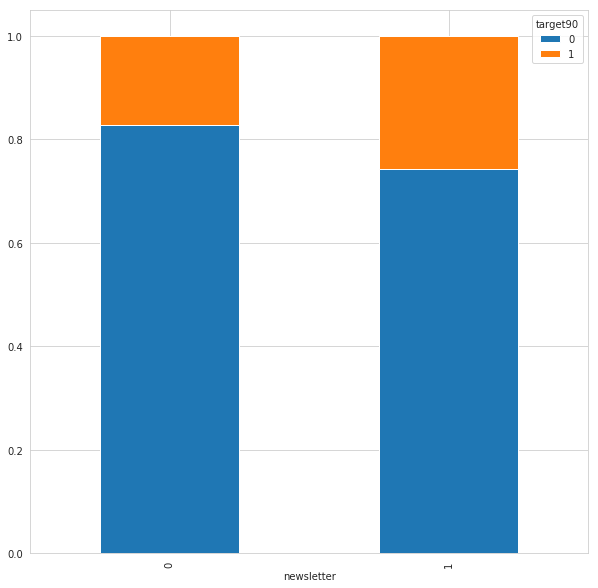

In [30]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

Chi-square test for the independence between target90 and gender
Result: dependent

In [31]:
scipy.stats.chi2_contingency(df_group1)

(2.4730659557007564, 0.11581182160516276, 1, array([[0.78491176, 0.21508824],
        [0.78491176, 0.21508824]]))

Target90 against domain (assumption: domain may be an indicator that if you are a sophisticated user)

In [32]:
df_group1 = df.groupby(['target90','domain'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

<function matplotlib.pyplot.legend(*args, **kwargs)>

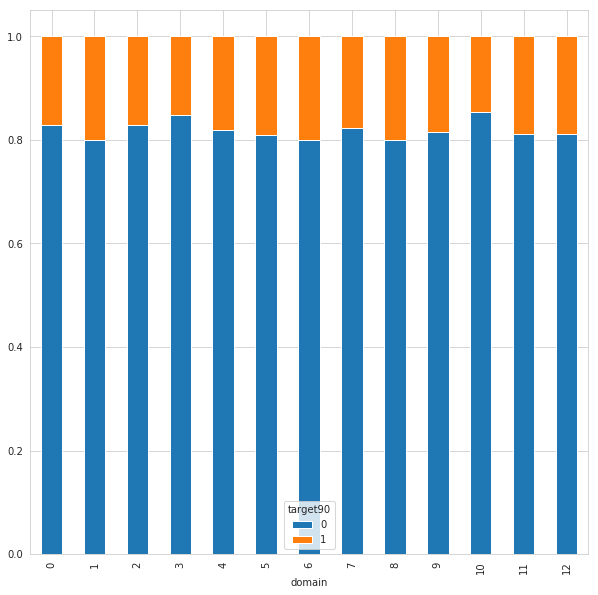

In [33]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )
plt.legend
# result: not dependent - drop this column 

In [34]:
scipy.stats.chi2_contingency(df_group1)

(0.02420411527161977, 0.9999999999999957, 12, array([[0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532],
        [0.81895468, 0.18104532]]))

In [35]:
# Target90 against payment type
df_group1 = df.groupby(['target90','paymenttype'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

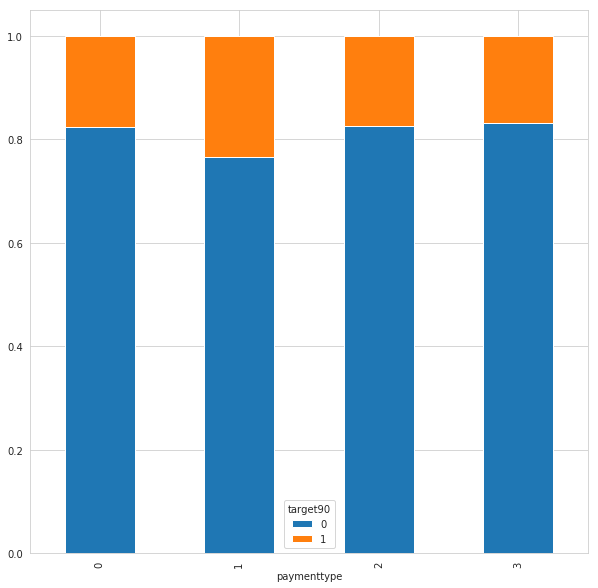

In [36]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

In [37]:
scipy.stats.chi2_contingency(df_group1)
# result: dependent

(0.018532689103539616, 0.9993327122492681, 3, array([[0.81164201, 0.18835799],
        [0.81164201, 0.18835799],
        [0.81164201, 0.18835799],
        [0.81164201, 0.18835799]]))

In [38]:
# target90 against deliverytype
df_group1 = df.groupby(['target90','deliverytype'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

In [39]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

In [40]:
scipy.stats.chi2_contingency(df_group1)
#result: dependent

(2.7186499336809002, 0.09918187269132235, 1, array([[0.79561135, 0.20438865],
        [0.79561135, 0.20438865]]))

In [41]:
# target90 againset voucher (if previous vouncher cashed or not)
df_group1 = df.groupby(['target90','voucher'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

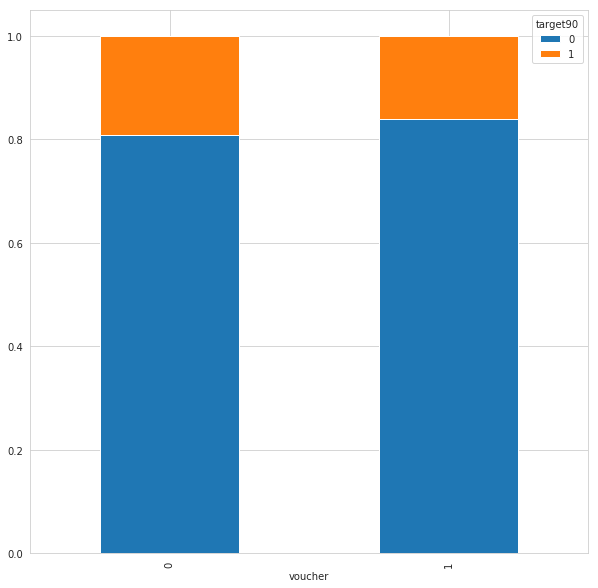

In [42]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

In [43]:
scipy.stats.chi2_contingency(df_group1)
#result: dependent

(3.2355574753008804, 0.0720557761963085, 1, array([[0.82387175, 0.17612825],
        [0.82387175, 0.17612825]]))

In [44]:
# target90 againset case
df_group1 = df.groupby(['target90','case'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

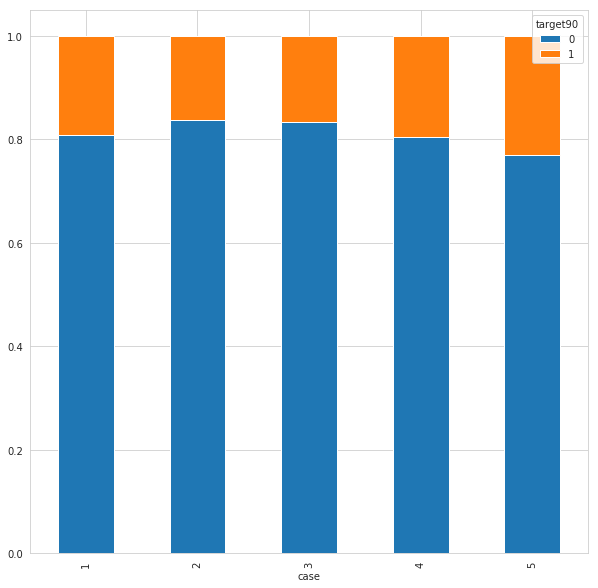

In [45]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

In [46]:
scipy.stats.chi2_contingency(df_group1)
# result: dependent

(0.018915576495697202, 0.9999555561220479, 4, array([[0.81054871, 0.18945129],
        [0.81054871, 0.18945129],
        [0.81054871, 0.18945129],
        [0.81054871, 0.18945129],
        [0.81054871, 0.18945129]]))

In [47]:
# target90 against entry
df_group1 = df.groupby(['target90','entry'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

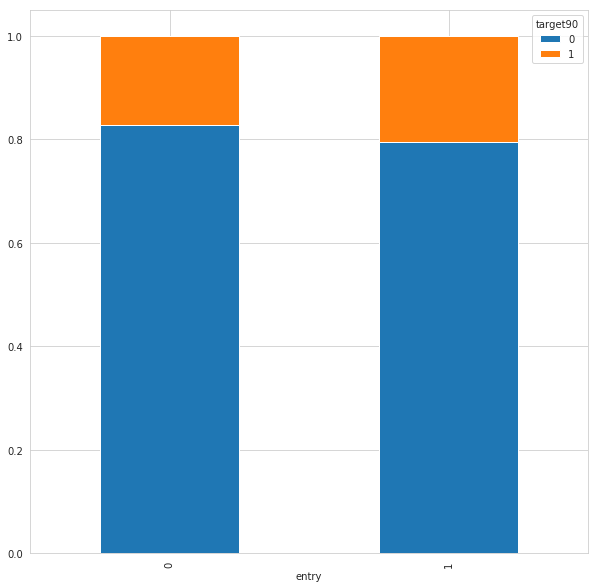

In [48]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

In [49]:
scipy.stats.chi2_contingency(df_group1)
# result: dependent

(3.0477121966968017, 0.08085096056183189, 1, array([[0.81061479, 0.18938521],
        [0.81061479, 0.18938521]]))

In [50]:
# target90 against shippingcosts
df_group1 = df.groupby(['target90','shippingcosts'])['target90'].count().unstack('target90').fillna(99)
df_group1=df_group1.transpose()
df_group1=df_group1/df_group1.sum(axis=0)
df_group1=df_group1.transpose()

In [51]:
df_group1.plot(kind='bar', figsize=(10,10), stacked = True )

In [52]:
scipy.stats.chi2_contingency(df_group1)
# result: dependent

(3.1740024247106255, 0.07481888745451815, 1, array([[0.84038217, 0.15961783],
        [0.84038217, 0.15961783]]))

### Conclusion (Can my independent variables predict target 90?):
1. Domain and target90 are independent, so our assumption is not right, drop the column.
2. For all categorical variables: newsletter, paymenttype, deliverytype, case, voucher, entry, shippingcosts have an influence on target 90.

Correlation of 11 product categories and target 90

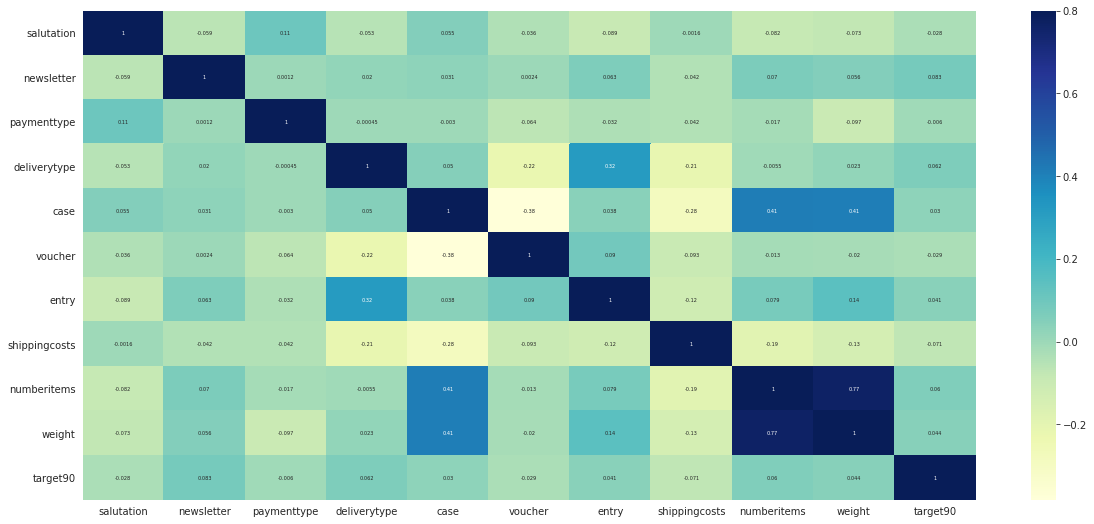

In [53]:
# correlation of other variables and target 90
df_heatmeat2 = df.loc [:,['salutation', 'newsletter', 'paymenttype','deliverytype','case','voucher', 'entry', 'shippingcosts','numberitems', 'weight', 'target90']]
corr = df_heatmeat2.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 5}, annot=True, cmap = "YlGnBu");

In [54]:
df_heatmap = df.iloc[:,26:38]
corr = df_heatmap.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 5}, annot=True, cmap = 'BuPu');

Conclusion from heatmap correlations: 
The heatmap gives us a visualization of the correlation matix, the correlation between weight & number of item is 0.77, 
Thus, we think they are highly correlcted, we need to remove one

Limitation: More thorough consideration of multicolinearity, maybe use PCA to remove features

## Variable Adoption

In [55]:
print(df.shape)
print(df['target90'].value_counts())

(32428, 38)
0    26377
1     6051
Name: target90, dtype: int64


### Easy drops and transformations

In [56]:
df = df.drop(['customernumber'], axis=1)

If deliverytype is collection/pickup, the deliverypostcode is always NAN. We think the postcodes may have some predictive power as a categorical variable, but they would require too much computational power because we would have to create many dummy variables. Therefore, we drop the invoicepostcode and the deliverypostcode and only leave the deliverytype.

In [57]:
df = df.drop(['delivpostcode', 'invoicepostcode'], axis=1)

Many missing values here and many different codes. We think the fact that a customer came as a result of a campaign is important. Therefore, the column is transformed to a dummy variable in the next line, we do not care about the specific type of advertising campaign.

In [58]:
print("Unique advertising data codes: ", df.advertisingdatacode.unique()) # Too many different codes, not usable as a categorical variable in that form.
df['hasadvertisingdatacode_custom'] = np.where(df['advertisingdatacode'].isna(), 0, 1) # Better transform it into boolean; it is not important which campaign it was, it is more important that the customer was acquired through a campaign at all.
df = df.drop(['advertisingdatacode'], axis=1) # And delete the old column.
print(df['hasadvertisingdatacode_custom'].value_counts())

Unique advertising data codes:  ['BL' nan 'BD' 'AQ' 'AB' 'BQ' 'CA' 'BX' 'BM' 'BT' 'BR' 'AE' 'BC' 'BB' 'AR'
 'BS' 'BO' 'AP' 'BF' 'BZ' 'AI' 'BY' 'AW' 'AL' 'AK' 'AM' 'AV' 'AT' 'BG'
 'AX' 'BI' 'AY' 'AH' 'AO' 'AZ' 'BK' 'AG' 'BV' 'AD' 'BA' 'AF' 'AU' 'BE'
 'AS' 'AC']
0    25905
1     6523
Name: hasadvertisingdatacode_custom, dtype: int64


### Easy drops and transformations

We assume the people that have "other" domains may take their account more serious (because they do not just use a trash email account) or they may be more sophisticated users.

In [59]:
df['domain_custom'] = np.where(df['domain'] == 12, 0, 1)

Already covered by number of individual item types (w0, w1...).

In [60]:
df = df.drop(['numberitems'], axis=1)

In [61]:
# Only 6 orders from category w8 shipped -> Drop.

In [62]:
df = df.drop(['w8'], axis=1)

### Transforming date columns

In [63]:
df['date'] = pd.to_datetime(df['date'])
df['datecreated'] = pd.to_datetime(df['datecreated'])
df['deliverydatepromised'] = pd.to_datetime(df['deliverydatepromised'], errors='coerce')
df['deliverydatereal'] = pd.to_datetime(df['deliverydatereal'], errors='coerce')


### Assumption: Customers are dissatisfied when there is a delay and the duration of the delay is not very important.

In [64]:
df.loc[(df['deliverydatereal'] > df['deliverydatepromised']), 'deliveryontime_custom'] = 0
print("custom", df['deliveryontime_custom'].isna().sum())
df.loc[(df['deliverydatereal'] <= df['deliverydatepromised']), 'deliveryontime_custom'] = 1
df.loc[(df['w3'] > 0), 'deliveryontime_custom'] = 1 # Intangible good, no delivery time
df.loc[(df['w5'] > 0), 'deliveryontime_custom'] = 1 # Intangible good, no delivery time
df.loc[(df['w10'] > 0), 'deliveryontime_custom'] = 1 # Intangible good, no delivery time
df.loc[(df['cancel'] > 0), 'deliveryontime_custom'] = 1 # Intangible good, no delivery time
df = df.dropna(subset=['deliveryontime_custom']) # Only 34 NAs left for deliveryontime_custom. We just drop those.
df = df.drop(['deliverydatepromised', 'deliverydatereal'], axis=1) # Not needed anymore.

custom 30536


Create new dummy column that is 1 if the customer ordered at the day of account creation.

In [65]:
df['time_to_first_order_custom'] = df['date'] - df['datecreated']
df['time_to_first_order_custom'] = df['time_to_first_order_custom'].dt.days
print(df['time_to_first_order_custom'].dtypes)
df['time_to_first_order_custom'] = pd.to_numeric(df['time_to_first_order_custom'])
df['ordered_directly_after_account_creation_custom'] = np.where(df['time_to_first_order_custom'] == 0, 1, 0)
df = df.drop(['time_to_first_order_custom', 'date', 'datecreated'], axis=1) # Not needed anymore.

int64


We are more interested if there were any used items in the order and less interested in the exact number of used items.

In [66]:
df['used_custom'] = np.where(df['used'] >= 0, 1, 0)
df = df.drop(['used'], axis=1)

We are more interested if there were any canceled items in the order and less interested in the exact number of canceled items.

In [67]:
df['cancel_custom'] = np.where(df['cancel'] >= 0, 1, 0)
df = df.drop(['cancel'], axis=1)

EPA showed that there is little correlation between remit and the target variable.

In [68]:
df = df.drop(['remi'], axis=1)

#### Checking unique values of categorical variables and dropping variables with unwanted properties (e.g., outliers)

In [69]:
print("Columns with missing values: ", df.columns[df.isnull().any()])
print("Unique salutations: ", df.salutation.unique()) # No outliers found (0  = Ms; 1 = Mr; 2 = Company)
print("Values for each category: ", df.salutation.value_counts(normalize=True))
print("Unique titles: ", df.title.unique()) # No outliers found (0 = no title; 1 = title)
print("Values for each category: ", df.title.value_counts(normalize=True))

Columns with missing values:  Index([], dtype='object')
Unique salutations:  [1 0 2]
Values for each category:  0    0.550164
1    0.358091
2    0.091745
Name: salutation, dtype: float64
Unique titles:  [0 1]
Values for each category:  0    0.993023
1    0.006977
Name: title, dtype: float64


In [70]:
df = df.drop(['title'], axis=1) # Drop because very rare (<0.01%) (but still a burden when computing).
print("Unique domains: ", df.domain.unique()) # No outliers found (0 = aol.com; 1 = arcor.de; 2 = freenet.de; 3 = gmail.com; 4 = gmx.de; 5 = hotmail.de; 6 = online.de; 7 = onlinehome.de; 8 = t-online.de; 9 = web.de; 10 = yahoo.com; 11 = yahoo.de; 12 = others)
print("Values for each category:\n", df.domain.value_counts(normalize=True))
print("Unique newsletters: ", df.newsletter.unique()) # No outliers found (0 = no; 1 = yes)

Unique domains:  [ 4  8 12  1  9  3 11  5  0  7  6  2 10]
Values for each category:
 12    0.238501
9     0.214422
4     0.204328
8     0.113910
11    0.043866
5     0.040378
2     0.036920
0     0.036149
1     0.035161
6     0.016886
3     0.011761
10    0.004229
7     0.003488
Name: domain, dtype: float64
Unique newsletters:  [0 1]


In [71]:
print("Values for each category: ", df.newsletter.value_counts(normalize=True))
print("Unique models: ", df.model.unique()) # No outliers found (models 1, 2, 3)
print("Values for each category: ", df.model.value_counts(normalize=True))
df = df.drop(['model'], axis=1) # We did not understand what model means and thought it is better to drop it. We cannot test it for plausibility.

Values for each category:  0    0.830462
1    0.169538
Name: newsletter, dtype: float64
Unique models:  [1 3 2]
Values for each category:  1    0.579614
3    0.227079
2    0.193307
Name: model, dtype: float64


In [72]:
print("Unique payment types: ", df.paymenttype.unique()) # No outliers found (0 = Payment on invoice; 1 = Cash payment; 2 = Transfer from current account; 3 = Transfer from credit card)
print("Values for each category: ", df.paymenttype.value_counts(normalize=True))
print("Unique delivery types: ", df.deliverytype.unique()) # No outliers found (Delivery type: 0 = Dispatch; 1 = collection)

Unique payment types:  [0 2 3 1]
Values for each category:  0    0.464407
1    0.201982
2    0.201550
3    0.132061
Name: paymenttype, dtype: float64
Unique delivery types:  [0 1]


In [73]:
print("Values for each category: ", df.deliverytype.value_counts(normalize=True))
print("Unique voucher redeptions: ", df.voucher.unique()) # No outliers found (Voucher redeemed: 0 = No; 1 = Yes)
print("Values for each category: ", df.voucher.value_counts(normalize=True))
print("Unique values of goods (case): ", df.case.unique()) # No outliers found (Value of goods: 1 = low; 5 = high)

Values for each category:  0    0.798018
1    0.201982
Name: deliverytype, dtype: float64
Unique voucher redeptions:  [0 1]
Values for each category:  0    0.837809
1    0.162191
Name: voucher, dtype: float64
Unique values of goods (case):  [3 1 4 2 5]


In [74]:
print("Values for each category: ", df.case.value_counts(normalize=True))
print("Unique gift options: ", df.gift.unique()) # Almost never with gift option, drop (Gift option: 0 = No; 1 = Yes)
print("Values for each category: ", df.gift.value_counts(normalize=True))
df = df.drop(['gift'], axis=1)

Values for each category:  4    0.266593
3    0.219639
1    0.195900
2    0.192073
5    0.125795
Name: case, dtype: float64
Unique gift options:  [0 1]
Values for each category:  0    0.995431
1    0.004569
Name: gift, dtype: float64


In [75]:
print("Unique entry: ", df.entry.unique()) # No outliers found (Entry into the shop: 0 = Shop; 1 = Partner)
print("Values for each category: ", df.entry.value_counts(normalize=True))
print("Unique points redeemed: ", df.points.unique()) # Always 0, drop (Points redeemed: 0 = No; 1 = Yes)
print("Values for each category: ", df.points.value_counts(normalize=True))
df = df.drop(['points'], axis=1)
print("Unique shipping costs incurred: ", df.shippingcosts.unique()) # No outliers found (Shipping costs incurred: 0 = No; 1 = Yes)
print("Values for each category: ", df.shippingcosts.value_counts(normalize=True))

Unique entry:  [0 1]
Values for each category:  0    0.585016
1    0.414984
Name: entry, dtype: float64
Unique points redeemed:  [0]
Values for each category:  0    1.0
Name: points, dtype: float64
Unique shipping costs incurred:  [0 1]
Values for each category:  0    0.849602
1    0.150398
Name: shippingcosts, dtype: float64


#### Weights

In [76]:
print(df.weight.head(8))

2396     2219
7479     1187
21559     378
17193     869
6774     1260
6614      954
4171     1521
30213       2
Name: weight, dtype: int64


Some weights are 0, but this is plausible. There are non-tangible items in the product portfolio of the company. In fact, we checked the orders that have a weight of 0 and they consist of non-tangible items.
The weight has a strong correlation with the number of items and the types of items. As we still have these variables in our dataframe, we drop weight.

In [77]:
df = df.drop(['weight'], axis=1)

### Comparing before and after

Number of observations in original dataset vs. now:

In [78]:
number_observations_original
df.target90.count()

32394

Number of columns original: 37, after:

In [79]:
len(df.columns)

26

This number will now increase dramatically as we create dummy variables.

### Creating dummies and dropping original category columns.

In [80]:
df = pd.get_dummies(df, columns=['salutation', 'domain_custom', 'newsletter', 'paymenttype', 'deliverytype'])
df = pd.get_dummies(df, columns=['voucher', 'case', 'entry', 'cancel_custom', 'used_custom', 'shippingcosts', 'hasadvertisingdatacode_custom'])

### Standardize and normalize

In [81]:
df_standardized = (df[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w9', 'w10']]-df[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w9', 'w10']].mean())/df[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w9', 'w10']].std()
df_normalized = (df_standardized[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w9', 'w10']]-df_standardized[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w9', 'w10']].min())/(df_standardized[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w9', 'w10']].max()-df_standardized[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w9', 'w10']].min())
df.merge(df_normalized)
df.shape

/home/janspoerer/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/home/janspoerer/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/home/janspoerer/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/home/janspoerer/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/home/janspoerer/anaconda3/lib/pytho

(32394, 42)

### Final deletion of NAs

We used our domain knowledge to decide against performing PCA to reduce the number of features. We believe the variables selected are meaningful and we already identified colinear variables (number of items vs. number of individual item types; weight vs. number of individual item types).

In [82]:
df = df.dropna(how='any') # Little number of NAs was found! Data is already pretty clean.
print(df.shape)

(32394, 42)


In [83]:
corr_matrix = df.corr()
corr_matrix["target90"].sort_values(ascending=False)

target90                                          1.000000
newsletter_1                                      0.082814
shippingcosts_0                                   0.070667
deliverytype_1                                    0.061361
paymenttype_1                                     0.061361
case_5                                            0.042025
entry_1                                           0.040889
w1                                                0.033869
w5                                                0.031978
voucher_0                                         0.029493
w9                                                0.019191
salutation_0                                      0.019029
w3                                                0.018892
w0                                                0.016538
w2                                                0.015995
case_4                                            0.013456
deliveryontime_custom                             0.0087

In [84]:
#df = df.drop(['cancel_custom_1', 'used_custom_1', 'domain_custom_0', 'domain_custom_1', 'hasadvertisingdatacode_custom_0', 'hasadvertisingdatacode_custom_1', 'salutation_1'], axis = 1)
df = df.drop(['deliveryontime_custom', 'domain', 'case_1', 'w6', 
              'domain_custom_0', 'hasadvertisingdatacode_custom_1', 
              'hasadvertisingdatacode_custom_0', 'salutation_1',
              'domain_custom_1', 'w7', 'w4', 'cancel_custom_1', 'used_custom_1'], axis=1) # Not needed anymore.


# Modeling 

## Downsampling

In orther to avoid getting baised sample, the data frame was balanced during the downsampling. As a direct result of balancing, only about 12100 rows remains in the data frame devided equally between [Yes: 1] and [No: 0] for the dependent variable [target90: Re-order within 90 days]. It was decided not to downsample further more since the data frame has already not too high number of rows.

In [85]:
print("\n \n Data Frame")
print(df['target90'].value_counts())

from sklearn.utils import resample 
df_majority = df[df.target90==0]
df_minority = df[df.target90==1]
df_majority_balanced = resample(df_majority, 
                                n_samples=len(df_minority), 
                                replace=False, random_state=0) 
df_balanced = pd.concat([df_majority_balanced, 
                                  df_minority])
print("\n \n Cross Validation Data Frame After Balancing")
print(df_balanced['target90'].value_counts())


 
 Data Frame
0    26344
1     6050
Name: target90, dtype: int64

 
 Cross Validation Data Frame After Balancing
1    6050
0    6050
Name: target90, dtype: int64


## Data Partitioning

At this point, the data frame was partitioned into two data frames; (1) independent variables [X], and (2) the dependent variable [Y] which is target90. Furthermore, both data frames were divided into 80% training and 20% testing randomly. It was important to use [stratify=Y] to keep the balancing even after partitioning into testing and traning.

In [86]:
X = df_balanced.drop('target90', axis = 1)
Y = df_balanced['target90']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y,
                                                    test_size=0.20, random_state=0)

print("\n \n Training Data Frame")
print(Y_train.value_counts()) 
print("\n \n Testing Data Frame")
print(Y_test.value_counts())


 
 Training Data Frame
1    4840
0    4840
Name: target90, dtype: int64

 
 Testing Data Frame
1    1210
0    1210
Name: target90, dtype: int64


## Cross Validation and Grid Searching

In our approach, it was important to use cross-validation in order to minimize overfitting effects and to avoid wasting training data for testing purposes. Four complementary subsets were used in cross-validation. Whenever it was possible, grid searching was implemented to optimize the model hyperparameters (within the specified ranges) based on the full training set. Due to the limitation of our computers' computing powers, only small and limited ranges were tested.

The following models were used: Logistic Regression, Naive Bayes, Random Forest, Gradient Boosting, and Neural Network. A report was created to record the optimum results of each model for comparison porpuses. Best three models will be chosen for Ensembles.

In [87]:
cross_validation_number_of_folds = 4
from sklearn.metrics import accuracy_score

report = pd.DataFrame(columns=['Model','Mean Acc. Training','Standard Deviation','Acc. Test'])

## Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression(solver = 'lbfgs')
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lrmodel, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
print("\n \n  \n Logistic Regression  \n")
print("Accuracies = ", accuracies)
print("Mean = ", accuracies.mean())
print("SD = ", accuracies.std())
lrmodel.fit(X_train, Y_train)
Y_test_pred = lrmodel.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Logistic Regression', accuracies.mean(), accuracies.std(), accte]
print(report.loc[len(report)-1])


 
  
 Logistic Regression  

Accuracies =  [0.55950413 0.58636364 0.58140496 0.58677686]
Mean =  0.578512396694215
SD =  0.011176139120907876
Model                 Logistic Regression
Mean Acc. Training               0.578512
Standard Deviation              0.0111761
Acc. Test                        0.565289
Name: 0, dtype: object


## Naive Bayes

In [89]:
from sklearn.naive_bayes import GaussianNB
nbmodel = GaussianNB()
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(nbmodel, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
print("\n \n  \nNaive Bayes  \n")
print("Accuracies = ", accuracies)
nbmodel.fit(X_train, Y_train)
Y_test_pred = nbmodel.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Naive Bayes', accuracies.mean(), accuracies.std(), accte]
print(report.loc[len(report)-1])


 
  
Naive Bayes  

Accuracies =  [0.5607438  0.56570248 0.56322314 0.5785124 ]
Model                 Naive Bayes
Mean Acc. Training       0.567045
Standard Deviation     0.00684864
Acc. Test                0.552066
Name: 1, dtype: object


## Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier(random_state=0)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': np.arange(4, 12),
    'n_estimators': [60]
}
CV_rfmodel = GridSearchCV(estimator=rfmodel, param_grid=param_grid, cv=cross_validation_number_of_folds)
CV_rfmodel.fit(X_train, Y_train)
print("\n \n \n Random Forest \n")
print("Best parameters: ", CV_rfmodel.best_params_)
# Apply the best parameters
rfmodel = rfmodel.set_params(**CV_rfmodel.best_params_)
rfmodel.fit(X_train, Y_train)
Y_test_pred = rfmodel.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Random Forest',
                          CV_rfmodel.cv_results_['mean_test_score'][CV_rfmodel.best_index_],
                          CV_rfmodel.cv_results_['std_test_score'][CV_rfmodel.best_index_], accte]
print(report.loc[len(report)-1])


 
 
 Random Forest 

Best parameters:  {'max_depth': 8, 'n_estimators': 60}
Model                 Random Forest
Mean Acc. Training         0.572211
Standard Deviation        0.0147821
Acc. Test                  0.565702
Name: 2, dtype: object


In [91]:
plt.plot(range(int(param_grid['max_depth'][0]), int(param_grid['max_depth'][-1] + 1)), CV_rfmodel.cv_results_['mean_test_score'])
plt.xlim(int(param_grid['max_depth'][0]), int(param_grid['max_depth'][-1])-1)
plt.xticks(range(int(param_grid['max_depth'][0]), int(param_grid['max_depth'][-1])))
plt.xlabel('Max Depth (n_estimators const. at 60)')
plt.ylabel('Accuracy')
plt.title('Random Forest: Comparison of Accuracies (n_estimators const. at 60)')
plt.show()

## Gradient Boosting Classifier

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
gbmodel = GradientBoostingClassifier(random_state=0)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': np.arange(1, 6),
    'subsample': [0.8],
    'n_estimators': [100],
    'learning_rate': [0.2]
}
CV_gbmodel = GridSearchCV(estimator=gbmodel, param_grid=param_grid, cv=cross_validation_number_of_folds)
CV_gbmodel.fit(X_train, Y_train)
print("\n \n \n Gradient Boosting Classifier  \n")
print(CV_gbmodel.best_params_)


 
 
 Gradient Boosting Classifier  

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}


In [93]:
gbmodel = gbmodel.set_params(**CV_gbmodel.best_params_)
gbmodel.fit(X_train, Y_train)
Y_test_pred = gbmodel.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Gradient Boosting (grid)',
                          CV_gbmodel.cv_results_['mean_test_score'][CV_gbmodel.best_index_],
                          CV_gbmodel.cv_results_['std_test_score'][CV_gbmodel.best_index_], accte]
print(report.loc[len(report)-1])

print(CV_rfmodel.cv_results_['mean_test_score'])

Model                 Gradient Boosting (grid)
Mean Acc. Training                    0.577893
Standard Deviation                  0.00882645
Acc. Test                             0.581818
Name: 3, dtype: object
[0.56725207 0.56745868 0.56890496 0.5714876  0.57221074 0.56838843
 0.56621901 0.56735537]


In [94]:
plt.plot(range(int(param_grid['max_depth'][0]), int(param_grid['max_depth'][-1] + 1)), CV_gbmodel.cv_results_['mean_test_score'])
plt.xlim(int(param_grid['max_depth'][0]), int(param_grid['max_depth'][-1])-1)
plt.xticks(range(int(param_grid['max_depth'][0]), int(param_grid['max_depth'][-1])))
plt.xlabel('Max Depth (subsample=0.8, n_estimators=100, learn_rate=0.2)')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting: Comparison of Accuracies')
plt.show()

## Neural Network

In [95]:
from sklearn.neural_network import MLPClassifier
nnetmodel = MLPClassifier(solver='lbfgs', random_state=0)
from sklearn.model_selection import GridSearchCV
param_grid ={
        'hidden_layer_sizes': np.arange(1, 5),
        'alpha':  np.arange(10, 16),
        'activation': ['identity', 'logistic', 'tanh', 'relu']
}
CV_nnetmodel = GridSearchCV(estimator=nnetmodel, param_grid=param_grid, n_jobs=-1, verbose=2, cv=cross_validation_number_of_folds)
CV_nnetmodel.fit(X_train, Y_train)
print("\n \n \n Neural Network Classifier  \n")
print("Best parameters: ", CV_nnetmodel.best_params_)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:   44.2s finished



 
 
 Neural Network Classifier  

Best parameters:  {'activation': 'relu', 'alpha': 14, 'hidden_layer_sizes': 4}


In [96]:
nnetmodel = nnetmodel.set_params(**CV_nnetmodel.best_params_)
nnetmodel.fit(X_train, Y_train)
accuracies = cross_val_score(nnetmodel, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
Y_test_pred = nnetmodel.predict(X_test)
acctest = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Neural Network', accuracies.mean(), accuracies.std(), acctest]
print(report.loc[len(report)-1])

Model                 Neural Network
Mean Acc. Training          0.583264
Standard Deviation        0.00901783
Acc. Test                   0.576446
Name: 4, dtype: object


## Final Report

In [97]:
print(report)

                      Model  Mean Acc. Training  Standard Deviation  Acc. Test
0       Logistic Regression            0.578512            0.011176   0.565289
1               Naive Bayes            0.567045            0.006849   0.552066
2             Random Forest            0.572211            0.014782   0.565702
3  Gradient Boosting (grid)            0.577893            0.008826   0.581818
4            Neural Network            0.583264            0.009018   0.576446


Different models showed very comparable results with accuracies close to 60%. Training and testing accuricies with small differences show that overfitting issues ware almost eliminated. The difficulty to increase the accuricies above 60% may indicate the need to provide alternative or additional dataset for the same problem.

For Esambles, best models are chosen based on their accuricies and stabilities. In our case, all applied models provide very simillar performance. Since there is very low variation, it may not be important to apply Ensamles. However, authers just interested to test Ensamles for future emplementations. Only three modles out of five were selected as following: Logistic Regression, and Neural Network, Gradient Boosting. Since Gradient Boosting and Random Forest are almost the same appraoch, one of them was selected.

## Ensembles

### Voting Ensembles

In [98]:
from mlxtend.classifier import EnsembleVoteClassifier
ens1model = EnsembleVoteClassifier(clfs=[lrmodel, nnetmodel, gbmodel], weights=[1,1,1])
accuracies = cross_val_score(ens1model, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
ens1model.fit(X_train, Y_train)
Y_test_pred = ens1model.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Ensemble (equal, hard)', accuracies.mean(), accuracies.std(), accte]
print(report.loc[len(report)-1])

Model                 Ensemble (equal, hard)
Mean Acc. Training                  0.581095
Standard Deviation                0.00853571
Acc. Test                           0.577686
Name: 5, dtype: object


In [99]:
from mlxtend.classifier import EnsembleVoteClassifier
ens1model = EnsembleVoteClassifier(clfs=[lrmodel, nnetmodel, gbmodel], weights=[1,1,1], voting='soft')
accuracies = cross_val_score(ens1model, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
ens1model.fit(X_train, Y_train)
Y_test_pred = ens1model.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Ensemble (equal, soft)', accuracies.mean(), accuracies.std(), accte]
print(report.loc[len(report)-1])

Model                 Ensemble (equal, soft)
Mean Acc. Training                  0.580992
Standard Deviation                0.00996459
Acc. Test                           0.579339
Name: 6, dtype: object


In [100]:
print('Comparison with Ensemble (weighting):')
ens2model = EnsembleVoteClassifier(clfs=[lrmodel, nnetmodel, gbmodel], weights=[1,2,1])
accuracies = cross_val_score(ens2model, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
ens2model.fit(X_train, Y_train)
Y_test_pred = ens2model.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Ens. (weighted, hard)', accuracies.mean(), accuracies.std(), accte]
print(report.loc[len(report)-1])

Comparison with Ensemble (weighting):
Model                 Ens. (weighted, hard)
Mean Acc. Training                 0.582955
Standard Deviation               0.00976718
Acc. Test                           0.57562
Name: 7, dtype: object


In [101]:
print('Comparison with Ensemble (Soft Voting):')
ens3model = EnsembleVoteClassifier(clfs=[lrmodel, nnetmodel, gbmodel], weights=[1,1,2], voting='soft')
accuracies = cross_val_score(ens3model, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
ens3model.fit(X_train, Y_train)
Y_test_pred = ens3model.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Ens. (weighted, soft)', accuracies.mean(), accuracies.std(), accte]
print(report.loc[len(report)-1])

Comparison with Ensemble (Soft Voting):
Model                 Ens. (weighted, soft)
Mean Acc. Training                 0.579236
Standard Deviation               0.00899828
Acc. Test                          0.585124
Name: 8, dtype: object


### Stacking Ensemble

In [102]:
from sklearn.linear_model import LogisticRegression
lr_ensemble = LogisticRegression()

print('Comparison with Stacking based on Logistic Regression:')
from mlxtend.classifier import StackingClassifier
stens1model = StackingClassifier(classifiers=[lrmodel, nnetmodel, gbmodel],
                                 use_probas=True,
                                 average_probas=False,
                                 meta_classifier=lr_ensemble)
accuracies = cross_val_score(stens1model, X_train, Y_train, scoring='accuracy', cv=cross_validation_number_of_folds)
stens1model.fit(X_train, Y_train)
Y_test_pred = stens1model.predict(X_test)
accte = accuracy_score(Y_test, Y_test_pred)
report.loc[len(report)] = ['Stacking Ensemble', accuracies.mean(), accuracies.std(), accte]
print(report.loc[len(report)-1])

Comparison with Stacking based on Logistic Regression:


/home/janspoerer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/janspoerer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/janspoerer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/janspoerer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model                 Stacking Ensemble
Mean Acc. Training             0.577479
Standard Deviation           0.00669817
Acc. Test                      0.577686
Name: 9, dtype: object


/home/janspoerer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [103]:
print(report)

                      Model  Mean Acc. Training  Standard Deviation  Acc. Test
0       Logistic Regression            0.578512            0.011176   0.565289
1               Naive Bayes            0.567045            0.006849   0.552066
2             Random Forest            0.572211            0.014782   0.565702
3  Gradient Boosting (grid)            0.577893            0.008826   0.581818
4            Neural Network            0.583264            0.009018   0.576446
5    Ensemble (equal, hard)            0.581095            0.008536   0.577686
6    Ensemble (equal, soft)            0.580992            0.009965   0.579339
7     Ens. (weighted, hard)            0.582955            0.009767   0.575620
8     Ens. (weighted, soft)            0.579236            0.008998   0.585124
9         Stacking Ensemble            0.577479            0.006698   0.577686


As expected, Ensembles have no additional accuracies over those provided by the models without Ensembles

# Conclusions and Recommendations

## Conclusions

Is the method feasible in practice?
* Yes, the media dealer aggregated over 30,000 rows of data about their customers. We therefore conclude that the marketing department could implement a data analytics model and use it on a regular basis for this specific purpose. The computing power needed is limited and the person that performs the analysis could work with a script that runs all steps from preprocessing to reporting. A qualified data analyst may be necessary to deal with changes in the data input and to refine the model (e.g., if new interesting variables are added to the ERP system). Scalability should not be a problem. In addition to implementing a predictive system, there should also be an evalution process in place that makes sure that the results are measured and compared to actual outcomes. Also, one should measure if doing the prediction actually pays of enough (cost for making the predictions vs. gains from better decisions).
* It would be interesting to know what the "Model" variable measures. We dropped this variable because we could not check the value for plausibility.

One deciding factor could be the return rate of the customer. Customers with high return rates should not be actively targeted because we believe that their contribution margin is lower than the contribution margin of customers that do not return their orders.

## Recommendations

1. The models' accuracy may be increased by testing wider ranges of hyperparameters using grid search. In our case, we were limited since it takes a long time using our personal computers. 
2. The difficulty to increase the accuracies above 60% may indicate the need to provide alternative or additional dataset for the same problem.